# Imports

In [128]:
import os
from train import Train
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from testModel import TestModel
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
from sklearn.model_selection import train_test_split
import re
import nltk
import contractions
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/joaocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [129]:
# Reading the file and converting it to a DataFrame
def read_file_to_dataframe(filename):
    data = []
    
    with open("./data/" + filename, 'r', encoding='utf-8') as file:
        for linha in file:
            linha = linha.strip()  # Remove leading/trailing spaces and newlines
            filme = linha.split('\t')  # Split by tab
            data.append(filme)  # Append the row to the data list
    
    # Convert the list of rows to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df


# Variaveis onde está os ficheiros de treino e o modelo

In [130]:
#file onde já está o modelo treinado"
model=None
newPKL = "joao3"


#limpesa de ficheiro de treino
data="train"
#ficheiro onde vai ser feita ao autoavaliacao
avaliation = "test_no_labels"

In [131]:
print("\033[34mData to DataFrame\n\033[0m")
# Example usage
df = read_file_to_dataframe(data+".txt")
print(df)

Data to DataFrame

                              0          1        2                        3  \
0                  Ela Cheppanu     Telugu  romance                   Ramana   
1     A Nightmare on Elm Street   American   horror             Samuel Bayer   
2               American Gothic   American   horror               John Hough   
3                          Gang  Bollywood    crime              Mazhar Khan   
4            Intimate Relations    British    drama            Charles Frank   
...                         ...        ...      ...                      ...   
8036              Sa 'Yo Lamang   Filipino    drama          Laurice Guillen   
8037          The Lemon Sisters   American    drama             Joyce Chopra   
8038      Dil Ne Phir Yaad Kiya  Bollywood  romance                  Unknown   
8039  Rehnaa Hai Terre Dil Mein  Bollywood  romance            Gautham Menon   
8040             Things to Come    British   sci-fi  William Cameron Menzies   

                    

8041


Average word count: 370.33


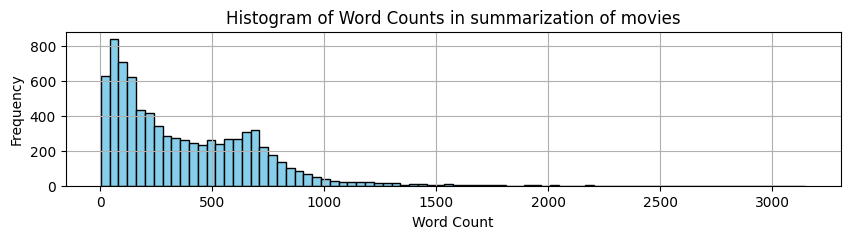

In [132]:
# histogram of word count
print(len(df))

df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


the: 161014
to: 111607
and: 106034
a: 80092
of: 53504
is: 49072
his: 43843
in: 43811
he: 30869
that: 30744


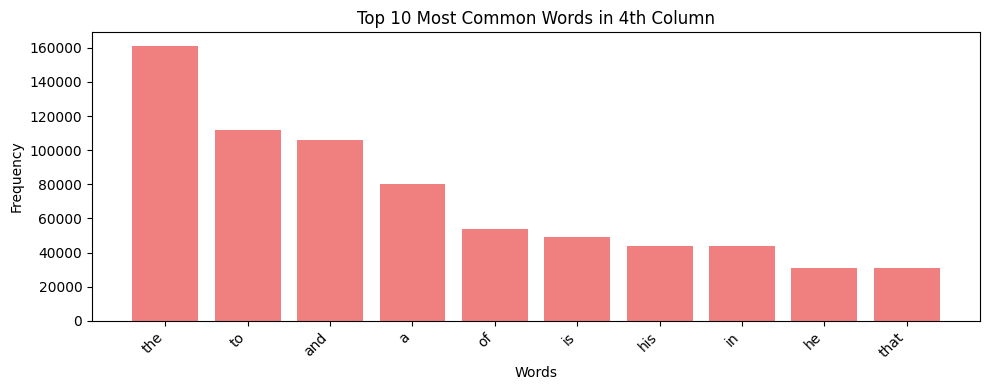

In [133]:
# Flatten all words from the 4th column into a single list
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

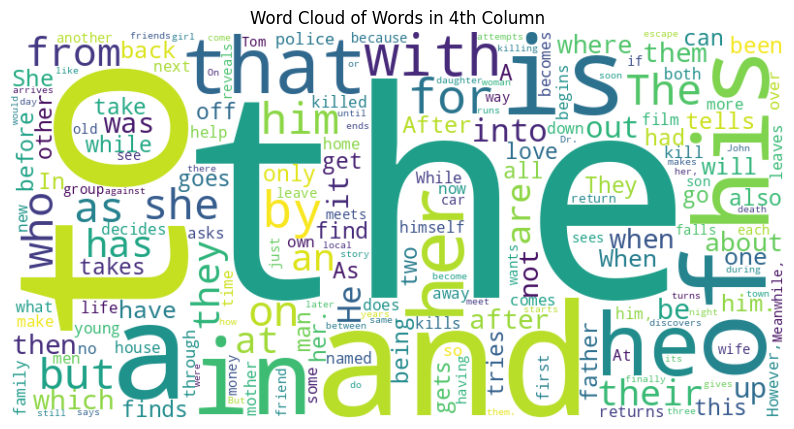

In [134]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

In [135]:
# Check for typos using the pyspellchecker
spell = SpellChecker()
misspelled_words = spell.unknown(all_words)  # Identify misspelled words

# Display the number of potential typos
print(f"Number of potential typos: {len(misspelled_words)}")

# Optionally, print the misspelled words
print("\nPotential typos detected:")
for word in misspelled_words:
    print(word)

Number of potential typos: 110045

Potential typos detected:
creach),
three-sided
familyman
helms,
tony,
reilly),
brookhaven
50-50.
mothers.
görkem
detectives—kuroda
americans,
ned.
palsikar),
semmarai
block,
arnelo
venkat).
eva’s
siragusa),
beneficiary,
morple.
kfar
descend,
hola!
novac's
garnet.
youngers
fistfight,
(tejanos),
vinod's
carroon's
ignites.
allergy:
chronos'
costner)
mackenzie.[2]
pyre,
renu
huntsville
girhdarilal
stressed,
memsahib,
trouble.
stones.
crowson
(courtney
pekwarsky.
karande).
loan),
chronos
used.
auto-pilot,
saturn.
rapids,
dubon
bladesmith
eminem,
uma's
teasdale
together,
bone-dissolving
travis.
oranja)
'evil',
freeze.
florrie's
denys
“keep”
(pawel
nagano
lullaby-like
gotya
marvin.
voskov,
mind-reading
disorganised,
spellingberg.
actress.soumya(indrasish
panchali.
kasi.
(kartik
ohio
cheung
2,
identity,
docks.
gunn),
dan.
mahendra
(amit
murray)
browning.
father.[2][3]
tremont
miyafuji,
mechanism.
puglia)
holland,
breck
ngai.
marna
contest.
perrine).
spotlight

## Pre Processamento

In [136]:
# Function to standardize dates
def standardize_dates(text):
    def _month_to_number(month_name):
        try:
            return datetime.strptime(month_name, "%b").month  # Abbreviated month names (e.g., "Feb")
        except ValueError:
            try:
                return datetime.strptime(month_name, "%B").month  # Full month names (e.g., "February")
            except ValueError:
                return None  # Return None for invalid month names

    def _handle_two_digit_year(year):
        if not year:  # If year is None or empty
            return ""
        year = int(year)
        return year + 2000 if year < 100 else year

    # Date normalization using regex
    text = re.sub(
        r'(\b[A-Za-z]+) (\d{1,2})(?:st|nd|rd|th)?(?:,)? (\d{4})?',
        lambda match: (
            f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}/{match.group(3)}"
            if _month_to_number(match.group(1)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(2)):02d}/{_month_to_number(match.group(1)):02d}"
            if _month_to_number(match.group(1)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    # Handle formats like "8-Feb-2013"
    text = re.sub(
        r'(\d{1,2})(?:st|nd|rd|th)?[-/.](\b[A-Za-z]+)\b[-/.]?(\d{2,4})?',
        lambda match: (
            f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}/{_handle_two_digit_year(match.group(3))}"
            if _month_to_number(match.group(2)) is not None and match.group(3)  # Ensure month and year exist
            else f"{int(match.group(1)):02d}/{_month_to_number(match.group(2)):02d}"
            if _month_to_number(match.group(2)) is not None  # Ensure month exists
            else match.group(0)  # Return original text if invalid month
        ),
        text
    )

    return text

In [137]:
# lowercasing
def lowercase_text(text):
    return text.lower()

In [138]:
# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

In [139]:
# stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(text, stop_words=stop_words):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower()]
    return " ".join(filtered_words)

In [140]:
#contractions
def expand_contractions(text):
    if not isinstance(text, str) or not text:
        # Return an empty string or the original text if it's not a valid string
        return text

    try:
        # Use contractions.fix to expand contractions in the text
        return contractions.fix(text)
    except IndexError as e:
        print(f"IndexError encountered: {e}")
        # Optionally return the original text if there's an error
        return text


In [141]:
# Remove punctuation except for specific cases like "Dr." or "Mr."
def remove_punctuation(text):
    # Replace specific abbreviations with placeholders
    text = re.sub(r'\b(Dr|Mr|Ms|Mrs)\.', r'\1_PLACEHOLDER_', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Restore the abbreviations
    text = text.replace('_PLACEHOLDER_', '.')
    
    return text

In [142]:
print("\033[34mPre Processing the data\n\033[0m")
def preprocess_text(text):
    text = expand_contractions(text)       # Step 1: Expand contractions
    text = standardize_dates(text)         # Step 2: Normalize dates
    text = lowercase_text(text)            # Step 3: Convert to lowercase
    text = remove_punctuation(text)        # Step 4: Remove punctuation but keep specific cases
    text = remove_stopwords(text)          # Step 5: Remove stopwords
    text = lemmatize_text(text)            # Step 6: Lemmatize the text
    return text

# Example usage

df.iloc[:, 4] = df.iloc[:, 4].apply(preprocess_text)

print("\033[32mPre Processing Completed!\n\033[0m")

Pre Processing the data

IndexError encountered: string index out of range
IndexError encountered: string index out of range
Pre Processing Completed!



Average word count: 204.93


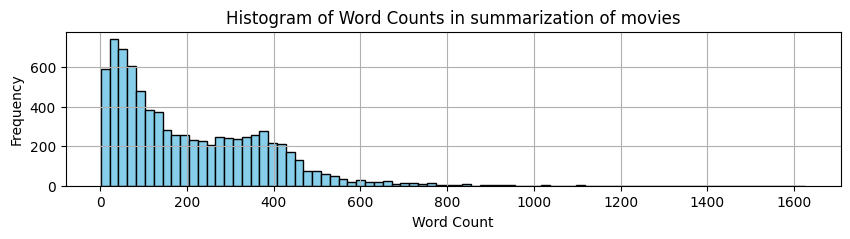

In [143]:
# histogram of word count after pre-processing
df['word_count'] = df[4].apply(lambda x: len(x.split()))
avg_word_count = df['word_count'].mean()
print(f'Average word count: {avg_word_count:.2f}')
# Plotting the histogram of word counts
plt.figure(figsize=(10, 2))
plt.hist(df['word_count'], bins=80, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts in summarization of movies')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

find: 7520
one: 6738
get: 6657
go: 6400
take: 6198
back: 5679
tell: 5446
father: 5130
friend: 4791
kill: 4709


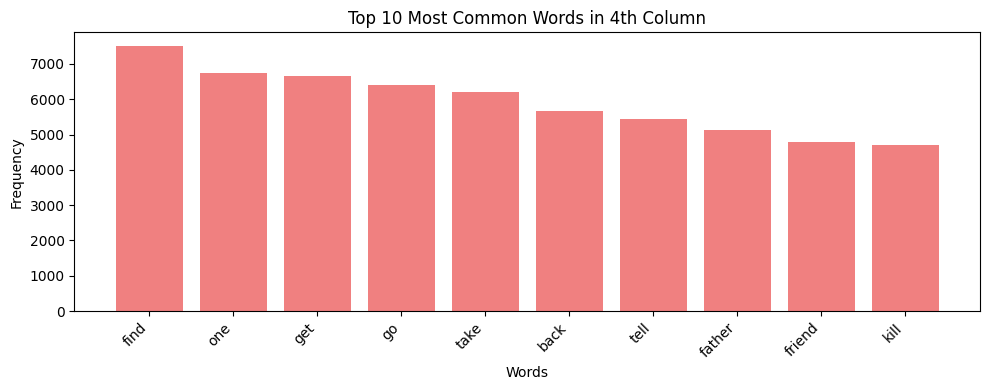

In [144]:
# Flatten all words from the 4th column into a single list after pre-processing
all_words = [word for row in df[4] for word in row.split()]

word_counter = Counter(all_words)

top_10_words = word_counter.most_common(10)

for word, count in top_10_words:
    print(f"{word}: {count}")

words, counts = zip(*top_10_words)

plt.figure(figsize=(10, 4))
plt.bar(words, counts, color='lightcoral')
plt.title('Top 10 Most Common Words in 4th Column')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate word labels for better readability
plt.tight_layout()
plt.show()

# Data after Pre Processing

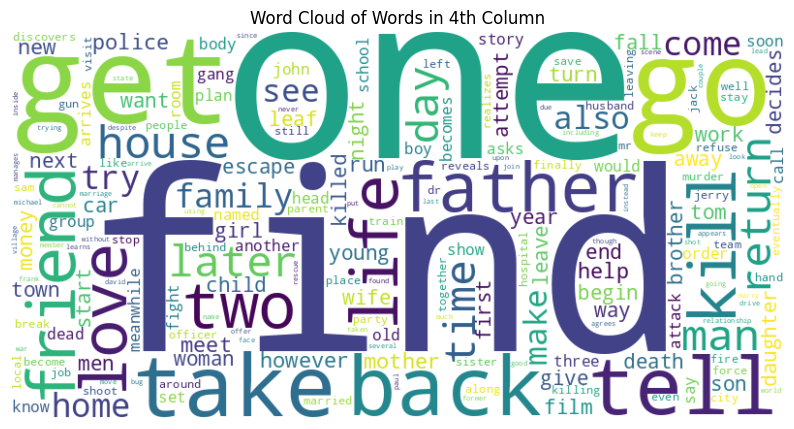

In [145]:
# Generate a word cloud after pre-processing
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Words in 4th Column')
plt.show()

## Carregar o modelo ou Criar um novo
#### Conforme o nome dado a variavel 'newPKL'

In [157]:
class SimpleFFNN:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = []
        self.biases = []
        self.vectorizer=None
        self.encoder=None
        for i in range(len(layer_sizes) - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))  # Xavier initialization
            self.weights.append(np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i + 1])))
            self.biases.append(np.zeros(layer_sizes[i + 1]))  # Initialize biases to zero for stability
    
    @classmethod
    def from_weights_bias(cls, weights, bias, vectorizer, encoder):
        instance = cls([])
        instance.weights = weights
        instance.biases = bias
        instance.vectorizer=vectorizer
        instance.encoder=encoder
        return instance
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):  # 2. Adding ReLU as a modern activation function
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))  # Subtraction for numerical stability
        return exp_x / np.sum(exp_x, axis=0)

    def forward(self, x):
        self.activations = [x]
        # Forward pass: Use ReLU in hidden layers
        for i in range(len(self.weights) - 1):
            x = self.relu(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x


    def train(self, x, y, epochs, learning_rate):
        for epoch in range(epochs):
            # 5. Implementing mini-batch gradient descent
            batch_size = 32
            num_batches = x.shape[0] // batch_size
            for batch in range(num_batches):
                batch_x = x[batch * batch_size:(batch + 1) * batch_size]
                batch_y = y[batch * batch_size:(batch + 1) * batch_size]
                for i in range(batch_size):
                    output = self.forward(batch_x[i])

                    # Calculate errors
                    errors = [batch_y[i] - output]

                    # Calculate errors for each layer
                    for l in range(len(self.weights) - 1, 0, -1):
                        error = errors[0].dot(self.weights[l].T)
                        errors.insert(0, error)

                    # Update weights and biases
                    for j in range(len(self.weights)):
                        if j == len(self.weights) - 1:
                            d_activations = errors[j]  # Output layer uses softmax, so no derivative
                        else:
                            d_activations = errors[j] * self.relu_derivative(self.activations[j + 1])  # 6. ReLU derivative for backprop
                        
                        self.weights[j] += np.outer(self.activations[j], d_activations) * learning_rate
                        self.biases[j] += d_activations * learning_rate
            
            loss = np.mean(np.square(y - self.forward(x)))
            print(f'Epoch {epoch}, Loss {loss}')
                
    #Guardar o modelo depois de o treinar
    def save_model(self, filename,vectorizer,encoder):
        with open(f'data/{filename}.pkl', 'wb') as f:
            pickle.dump({'weights': self.weights, 'biases': self.biases,'vectorizer': vectorizer, 'encoder':encoder}, f)
            
    #Usar o modelo para o poder testar
    def load_model(filename):
        with open(f'{filename}', 'rb') as f:
            data = pickle.load(f)
            return SimpleFFNN.from_weights_bias(data['weights'],data['biases'],data['vectorizer'],data['encoder'])
    
    def evaluate(self, X_test, y_test):
        # Forward pass for the test set
        y_pred = np.array([self.forward(x) for x in X_test])
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
        
        # 8. Expanded evaluation metrics
        accuracy = np.mean(y_pred_labels == y_test_labels)
        precision = np.sum((y_pred_labels == y_test_labels) & (y_test_labels == 1)) / np.sum(y_pred_labels == 1)
        recall = np.sum((y_pred_labels == y_test_labels) & (y_test_labels == 1)) / np.sum(y_test_labels == 1)
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        return accuracy, precision, recall, f1_score
    
    def predict(self, X):
        y_pred = np.array([self.forward(x) for x in X])
        y_pred_labels = np.argmax(y_pred, axis=1)  # Get the label with the highest probability
        return y_pred_labels

In [158]:
# Encode

def vectorize_and_encode(df, use_embeddings=False):
    plots = df[4].tolist()  # Text column
    genres = df[2].tolist()  # Label column

    if use_embeddings:
        # Use pre-trained embeddings (e.g., Word2Vec, GloVe, etc.) if necessary
        # Code for embedding handling goes here...
        pass
    else:
        # Use TF-IDF for text vectorization
        vectorizer = TfidfVectorizer(max_features=5000)
        X = vectorizer.fit_transform(plots).toarray()

    encoder = LabelBinarizer()
    y = encoder.fit_transform(genres)

    return X, y, vectorizer, encoder

In [159]:
# Split the data into training and testing sets
def split_data(X, y, test_size=0.2):
    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [160]:
# Carregar o modelo se ele já existir
if os.path.isfile("data/" + newPKL + ".pkl"):
    print("\033[34mLoading Model\n\033[0m")
    model = SimpleFFNN.load_model("data/" + newPKL + ".pkl")
    print("\033[32mLoading Completed!\n\033[0m")
else:
    print("\033[34mCreating a new Model\n\033[0m")
    X, y, vectorizer, encoder = vectorize_and_encode(df)
    X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

    layer_hidden = [50, 25, 9]
    learning_rate = 0.01
    epochs = 1
    model = SimpleFFNN([X_train.shape[1]] + layer_hidden + [y_train.shape[1]])
    model.train(X_train, y_train, epochs, learning_rate)
    model.save_model(newPKL, vectorizer, encoder)

Loading Model

Loading Completed!



# Teste do modelo com o ficheiro com as labels identificadas
##### 'train.txt'

In [161]:
y_pred = model.predict(X_test)

# Decodificar os rótulos numéricos para os rótulos de gênero
y_test_decoded = encoder.inverse_transform(y_test)
y_pred_decoded = encoder.inverse_transform(y_pred)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

# Obter os nomes dos gêneros
genre_labels = encoder.classes_

# Plotar a matriz de confusão com os rótulos dos gêneros
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=genre_labels)
disp.plot(cmap=plt.cm.Blues)  # Escolha o mapa de cores
plt.title("Confusion Matrix of Movie Genres")
plt.xticks(rotation=45)  # Para girar os rótulos no eixo x, se necessário
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1